In [41]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

# importing dataset from local drive
df = pd.read_csv('thyroidDF.csv') 

# dropping redundant attributes from df dataset
df.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', 'patient_id', 'referral_source'], axis=1, inplace=True)

# re-mapping target vaues to diagnostic groups
classes = {'-': 'negative',
             'A': 'hyperthyroid', 
             'B': 'hyperthyroid', 
             'C': 'hyperthyroid', 
             'D': 'hyperthyroid',
             'E': 'hypothyroid', 
             'F': 'hypothyroid', 
             'G': 'hypothyroid', 
             'H': 'hypothyroid'}

df['target'] = df['target'].map(classes) 
# dropping observations with 'target' null 
df.dropna(subset=['target'], inplace=True) 


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7546 entries, 0 to 9171
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  7546 non-null   int64  
 1   sex                  7296 non-null   object 
 2   on_thyroxine         7546 non-null   object 
 3   query_on_thyroxine   7546 non-null   object 
 4   on_antithyroid_meds  7546 non-null   object 
 5   sick                 7546 non-null   object 
 6   pregnant             7546 non-null   object 
 7   thyroid_surgery      7546 non-null   object 
 8   I131_treatment       7546 non-null   object 
 9   query_hypothyroid    7546 non-null   object 
 10  query_hyperthyroid   7546 non-null   object 
 11  lithium              7546 non-null   object 
 12  goitre               7546 non-null   object 
 13  tumor                7546 non-null   object 
 14  hypopituitary        7546 non-null   object 
 15  psych                7546 non-null   o

In [42]:

df['age'] = np.where((df.age > 100), np.nan, df.age)

<Axes: xlabel='target', ylabel='TBG'>

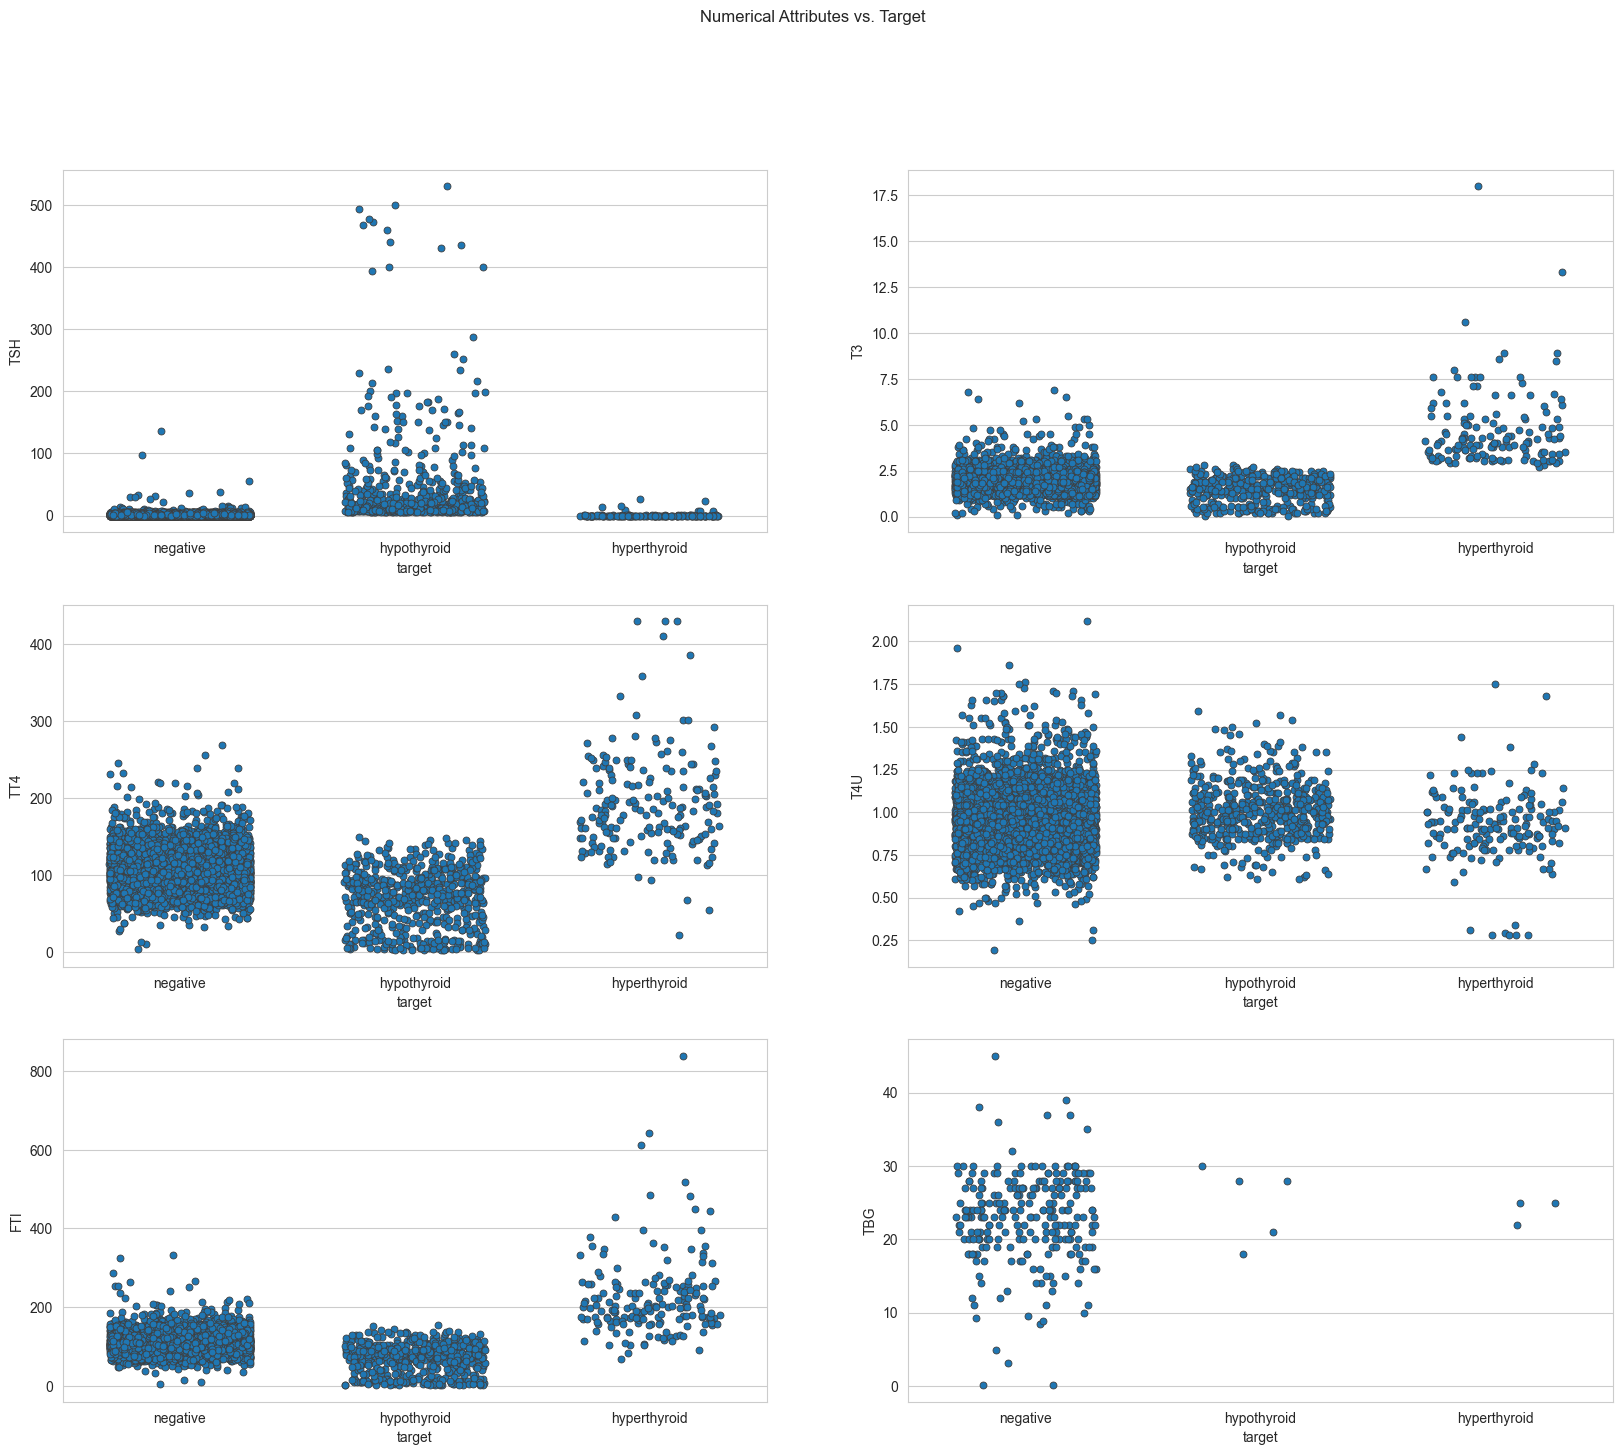

In [43]:
# setting up grid for multiple seaborn plots
fig, axes = plt.subplots(3,2,figsize=(20,16))
fig.suptitle('Numerical Attributes vs. Target')
sns.set_style('whitegrid');

# TSH vs. 'target'
sns.stripplot(x=df.target, y=df.TSH, linewidth=0.6, jitter= 0.3, ax=axes[0, 0])
# T3 vs. 'target'
sns.stripplot(x=df.target, y=df.T3, linewidth=0.6, jitter= 0.3, ax=axes[0, 1])
# TT4 vs. 'target'
sns.stripplot(x=df.target, y=df.TT4, linewidth=0.6, jitter= 0.3, ax=axes[1, 0])
# T4U vs. 'target'
sns.stripplot(x=df.target, y=df.T4U, linewidth=0.6, jitter= 0.3, ax=axes[1, 1])
# FTI vs. 'target'
sns.stripplot(x=df.target, y=df.FTI, linewidth=0.6, jitter= 0.3, ax=axes[2, 0])
# TBG vs. 'target'
sns.stripplot(x=df.target, y=df.TBG, linewidth=0.6, jitter= 0.3, ax=axes[2, 1])

In [44]:
# calculating missingess of entire DF
missingness = df.isnull().sum().sum() / df.count().sum()
print('Overall Missing values of df is: {:.2f}%'.format(missingness * 100))

# Create table for missing data analysis
def missing_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Analyze missing data
missing_table(df).head(10)

Overall Missing values of df is: 7.54%


,Total,Percent
TBG,7287,0.965677
T3,2209,0.292738
TSH,722,0.095680
T4U,676,0.089584
FTI,669,0.088656
TT4,354,0.046912
sex,250,0.033130
age,4,0.000530
goitre,0,0.000000
psych,0,0.000000


In [45]:
# dropping 'TBG' attribute from dataset
df.drop(['TBG'], axis=1, inplace=True)

# dropping 4 observations with abnormal 'age' from dataset
df.dropna(subset=['age'], inplace=True)

# changing sex of observations with ('pregnant' == True) & ('sex' == null) to Female
df['sex'] = np.where((df.sex.isnull()) & (df.pregnant == 't'), 'F', df.sex)

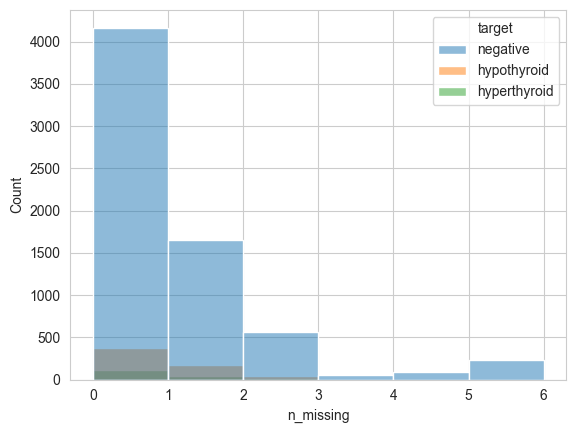

In [46]:
# count missing values per row
df['n_missing'] = df.isnull().sum(axis=1)
sns.histplot(df, x='n_missing', binwidth=1, hue='target');

In [47]:
# calculating missingess of entire DF
missing_values = df.isnull().sum().sum() / df.count().sum()
print('Overall Missing Values of df is: {:.2f}%'.format(missing_values * 100))

# remove rows with 3 or more missing values
df.drop(df.index[df['n_missing'] > 2], inplace=True)
print
missing_table(df).head(10)

Overall Missing Values of df is: 2.89%


,Total,Percent
T3,1910,0.267432
TSH,406,0.056847
T4U,290,0.040605
FTI,283,0.039625
sex,208,0.029123
TT4,6,0.000840
age,0,0.000000
goitre,0,0.000000
target,0,0.000000
psych,0,0.000000


In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,  classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

# replacing boolean strings with binary 0 and 1
df.replace('f', 0, inplace=True)
df.replace('t', 1, inplace=True)

# replacing sex with binary 0 and 1
df.replace('M', 0, inplace=True) # male mapped to 0
df.replace('F', 1, inplace=True) # female mapped to 1

xgbDF = df.replace(np.nan, 0)

# re-mapping target vaues to diagnostic groups
# *** I get different final results by ordering these classes differently ***
classes = {'negative': 0,
             'hypothyroid': 1, 
             'hyperthyroid': 2}

xgbDF['target'] = xgbDF['target'].map(classes) # re-mapping

# train and test split --> stratified
X = xgbDF.drop('target', axis=1).copy()
y = xgbDF['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

XGB Boost Experiments

Experiment 1

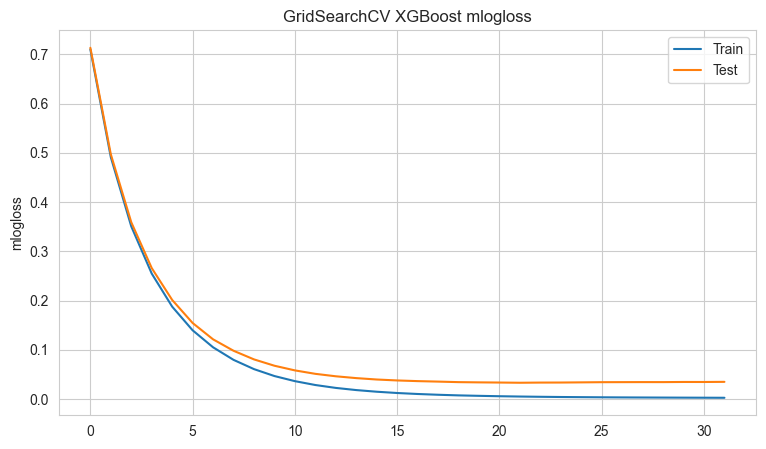


-------------------- Key Metrics --------------------

Accuracy: 0.99
Balanced Accuracy: 0.93


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      1.00      0.98       145
           2       0.85      0.80      0.82        44

    accuracy                           0.99      1786
   macro avg       0.94      0.93      0.93      1786
weighted avg       0.99      0.99      0.99      1786



In [49]:

## base run of model with default hyperparameters

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1, 
                            early_stopping_rounds=10, 
                            eval_metric=['merror','mlogloss'], 
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()


## ---------- Model Classification Report ----------


y_pred = xgb_clf.predict(X_test)



print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))



print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


Experiment 2

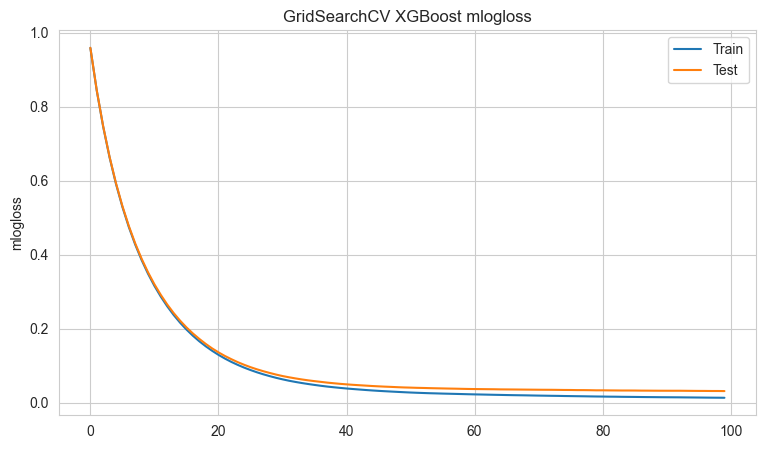


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      1.00      0.98       145
           2       0.90      0.82      0.86        44

    accuracy                           0.99      1786
   macro avg       0.95      0.94      0.94      1786
weighted avg       0.99      0.99      0.99      1786



In [50]:
## ---------- XGBoost model v2 ----------

xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=3,
                            reg_lambda=1, # default L2 value
                            subsample=1, # default subsample value
                            colsample_bytree=1, # default colsample_bytree value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, 
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()


## ---------- Model Classification Report ----------


y_pred = xgb_clf.predict(X_test)


print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


Experiment 3

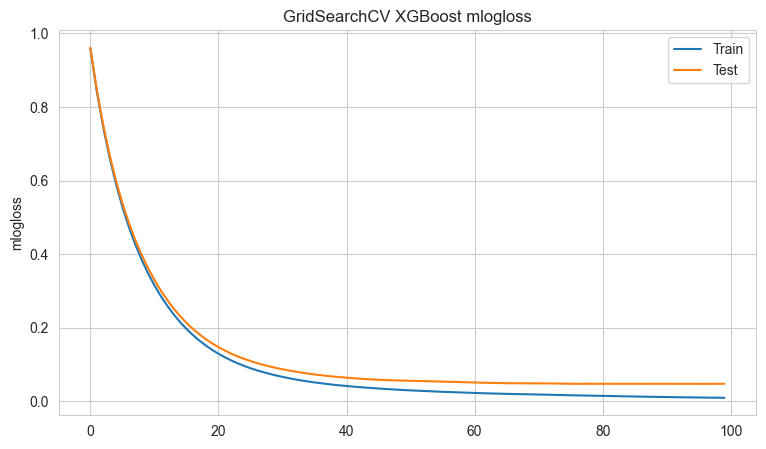


--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1597
           1       0.95      1.00      0.98       145
           2       0.76      0.93      0.84        44

    accuracy                           0.99      1786
   macro avg       0.90      0.97      0.94      1786
weighted avg       0.99      0.99      0.99      1786

---------------------- XGBoost ----------------------


In [51]:
## ---------- XGBoost model v3 ----------

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

# declaring and fitting xgb classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            missing=1,
                            gamma=0, # default gamma value
                            learning_rate=0.1,
                            max_depth=5, 
                            reg_lambda=1, # default L2 value
                            early_stopping_rounds=10,
                            eval_metric=['merror','mlogloss'],
                            seed=42)
xgb_clf.fit(X_train, 
            y_train,
            verbose=0, 
            sample_weight=sample_weights, 
            eval_set=[(X_train, y_train), (X_test, y_test)])

# preparing evaluation metric plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# xgboost 'mlogloss' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('GridSearchCV XGBoost mlogloss')
plt.show()

## ---------- Model Classification Report ----------


y_pred = xgb_clf.predict(X_test)

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))
print('---------------------- XGBoost ----------------------') # unnecessary fancy styling

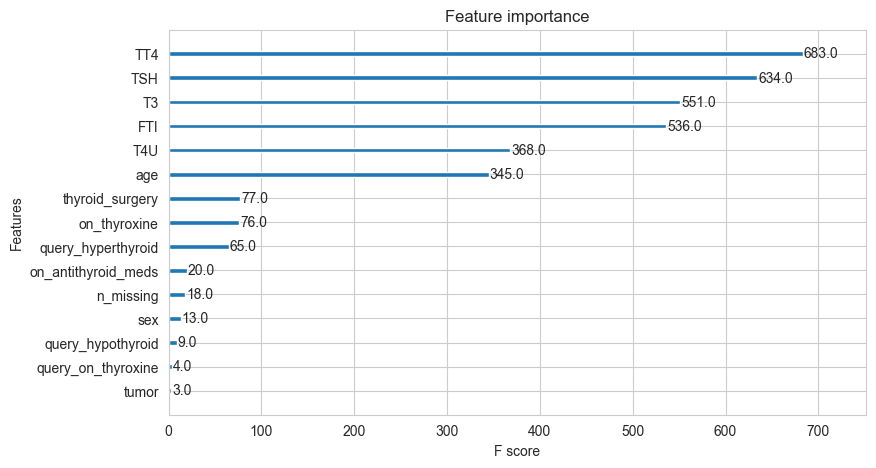

In [52]:
## ---------- Plot Feature Importance ----------


from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(9,5))
plot_importance(xgb_clf, ax=ax)
plt.show()

Random Forest Experiments

Experiment 1

In [53]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=700, random_state=42)

# Train the classifier on the training data
history=rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.9882418812989922
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.96      1.00      0.98       145
           2       0.89      0.75      0.81        44

    accuracy                           0.99      1786
   macro avg       0.95      0.91      0.93      1786
weighted avg       0.99      0.99      0.99      1786



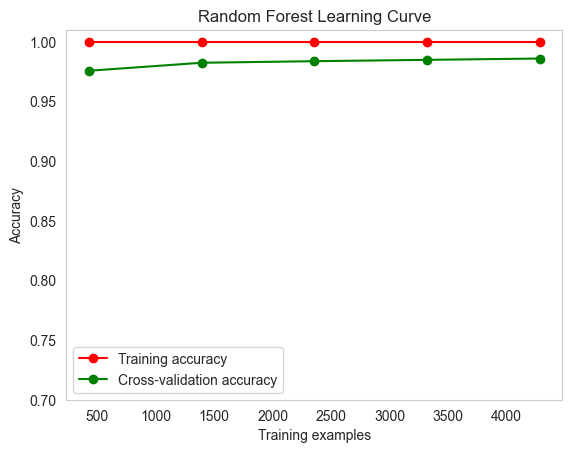

In [54]:

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Create a function to calculate accuracy on training and test sets
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")

    plt.legend(loc="best")
    return plt

# Plot learning curve
plot_learning_curve(rf_classifier, "Random Forest Learning Curve", X_train, y_train, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

plt.show()


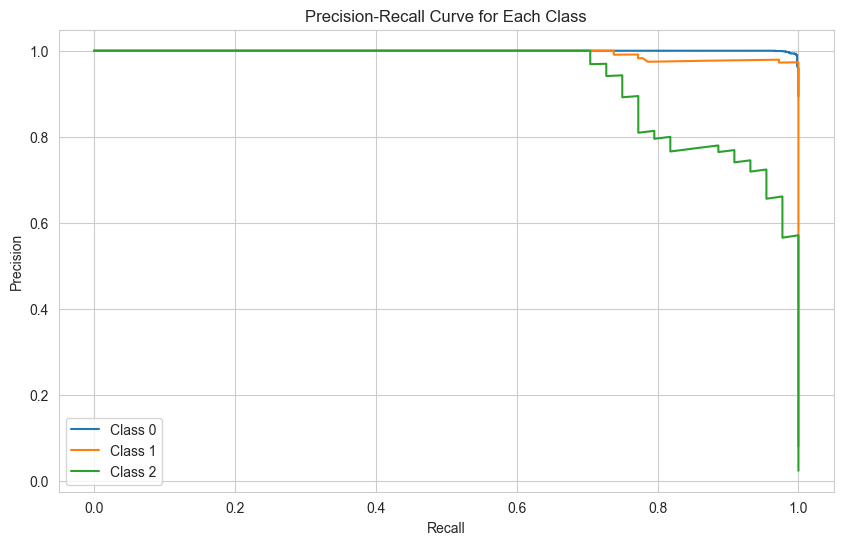

In [55]:
from sklearn.metrics import precision_recall_curve

# Make predictions on the test data
y_pred_proba = rf_classifier.predict_proba(X_test)

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 6))
for class_idx in range(y_pred_proba.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, class_idx], pos_label=class_idx)
    plt.plot(recall, precision, label=f'Class {class_idx}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()





Experiment 2

In [65]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report



# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=10)

# Train the classifier on the training data
history=rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9876819708846585
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.95      1.00      0.97       145
           2       0.92      0.75      0.83        44

    accuracy                           0.99      1786
   macro avg       0.95      0.91      0.93      1786
weighted avg       0.99      0.99      0.99      1786



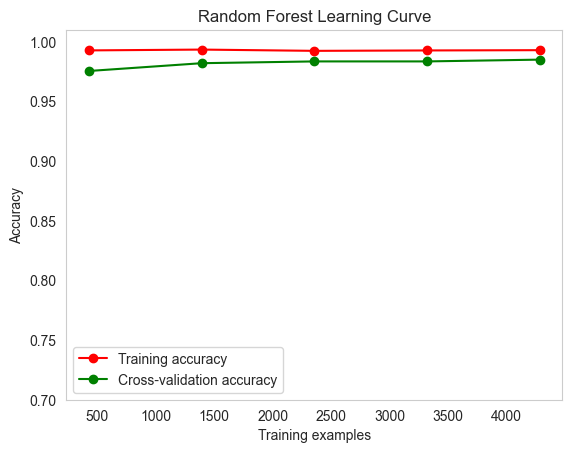

In [66]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Create a function to calculate accuracy on training and test sets
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")

    plt.legend(loc="best")
    return plt

# Plot learning curve
plot_learning_curve(rf_classifier, "Random Forest Learning Curve", X_train, y_train, ylim=(0.7, 1.01), cv=5, n_jobs=-1)

plt.show()


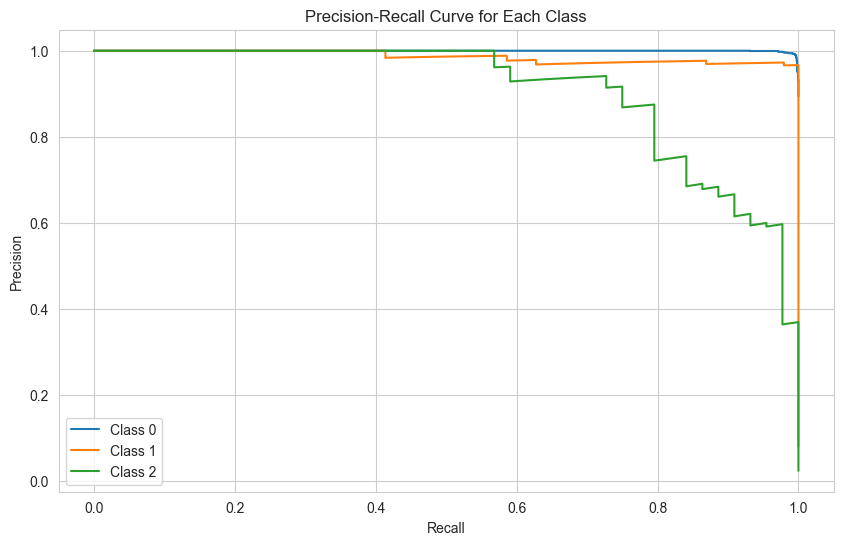

In [67]:
from sklearn.metrics import precision_recall_curve

# Make predictions on the test data
y_pred_proba = rf_classifier.predict_proba(X_test)

# Plot precision-recall curves for each class
plt.figure(figsize=(10, 6))
for class_idx in range(y_pred_proba.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, class_idx], pos_label=class_idx)
    plt.plot(recall, precision, label=f'Class {class_idx}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()

Ada Boost Experiments

Experiment 1

c:\Users\qazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\qazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


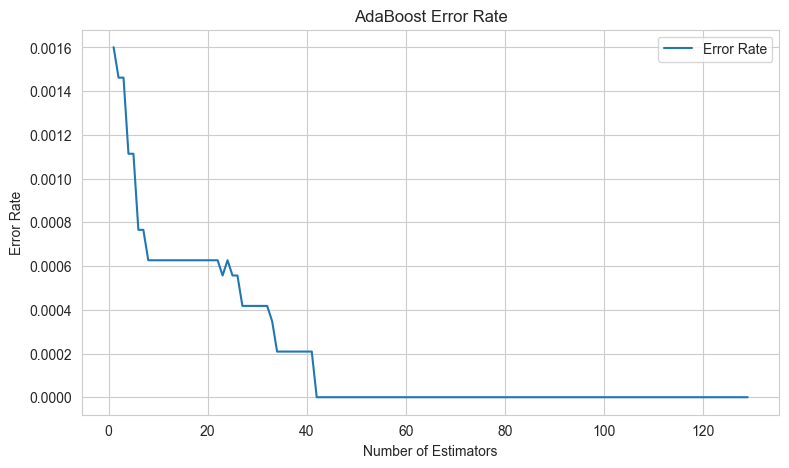


--------------- Classification Report (AdaBoost) ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      1.00      0.99       145
           2       0.83      0.80      0.81        44

    accuracy                           0.99      1786
   macro avg       0.93      0.93      0.93      1786
weighted avg       0.99      0.99      0.99      1786



In [62]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.utils.class_weight import compute_sample_weight

# Create sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize AdaBoostClassifier with DecisionTree base estimator
ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=10),  # You can adjust max_depth as needed
    n_estimators=300,
    learning_rate=0.01,
    random_state=42)

# Fit the AdaBoostClassifier
ada_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Get the error rate for each boosting iteration
error_rates = [zero_one_loss(y_train, pred, sample_weight=sample_weights) for pred in ada_clf.staged_predict(X_train)]

# Plot AdaBoost error curve
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(error_rates) + 1), error_rates, label='Error Rate')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.title('AdaBoost Error Rate')
plt.legend()
plt.show()

# Predict using the trained model
y_pred_ada = ada_clf.predict(X_test)

# Print classification report
print('\n--------------- Classification Report (AdaBoost) ---------------\n')
print(classification_report(y_test, y_pred_ada))


Experiment 2

c:\Users\qazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\qazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


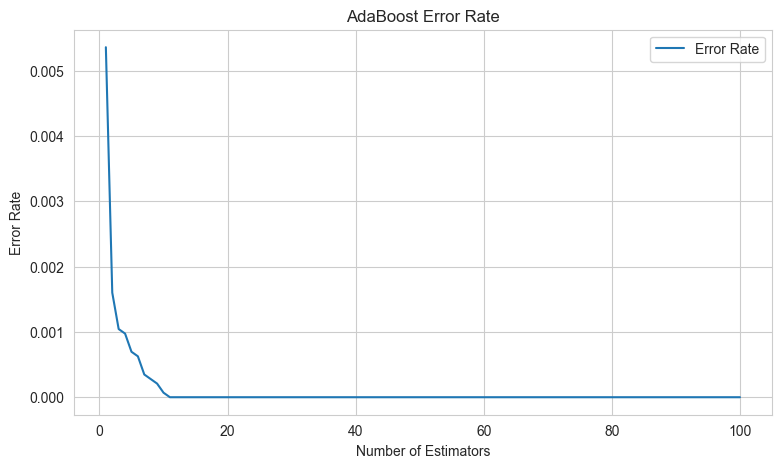


--------------- Classification Report (AdaBoost) ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      1.00      0.99       145
           2       0.85      0.80      0.82        44

    accuracy                           0.99      1786
   macro avg       0.94      0.93      0.93      1786
weighted avg       0.99      0.99      0.99      1786



In [60]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.utils.class_weight import compute_sample_weight

# Create sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize AdaBoostClassifier with DecisionTree base estimator
ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5),  # You can adjust max_depth as needed
    n_estimators=100,
    learning_rate=0.5,
    random_state=42)

# Fit the AdaBoostClassifier
ada_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Get the error rate for each boosting iteration
error_rates = [zero_one_loss(y_train, pred, sample_weight=sample_weights) for pred in ada_clf.staged_predict(X_train)]

# Plot AdaBoost error curve
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(error_rates) + 1), error_rates, label='Error Rate')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.title('AdaBoost Error Rate')
plt.legend()
plt.show()

# Predict using the trained model
y_pred_ada = ada_clf.predict(X_test)

# Print classification report
print('\n--------------- Classification Report (AdaBoost) ---------------\n')
print(classification_report(y_test, y_pred_ada))


Experiment 3

c:\Users\qazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\qazim\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


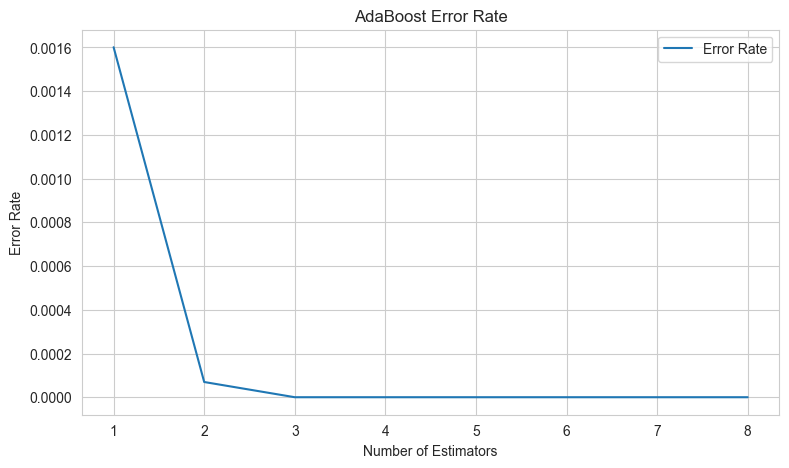


--------------- Classification Report (AdaBoost) ---------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1597
           1       0.97      0.98      0.98       145
           2       0.79      0.86      0.83        44

    accuracy                           0.99      1786
   macro avg       0.92      0.94      0.93      1786
weighted avg       0.99      0.99      0.99      1786



In [61]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.utils.class_weight import compute_sample_weight

# Create sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize AdaBoostClassifier with DecisionTree base estimator
ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=10),  # You can adjust max_depth as needed
    n_estimators=500,
    learning_rate=0.5,
    random_state=42)

# Fit the AdaBoostClassifier
ada_clf.fit(X_train, y_train, sample_weight=sample_weights)

# Get the error rate for each boosting iteration
error_rates = [zero_one_loss(y_train, pred, sample_weight=sample_weights) for pred in ada_clf.staged_predict(X_train)]

# Plot AdaBoost error curve
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(error_rates) + 1), error_rates, label='Error Rate')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.title('AdaBoost Error Rate')
plt.legend()
plt.show()

# Predict using the trained model
y_pred_ada = ada_clf.predict(X_test)

# Print classification report
print('\n--------------- Classification Report (AdaBoost) ---------------\n')
print(classification_report(y_test, y_pred_ada))
